In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def LoadData(fname):
    """Loads data from an NPZ file.

    Args:
        fname: NPZ filename.

    Returns:
        data: Tuple {inputs, target}_{train, valid, test}.
              Row-major, outer axis to be the number of observations.
    """
    npzfile = np.load(fname)

    inputs_train = npzfile['inputs_train'].T / 255.0
    inputs_valid = npzfile['inputs_valid'].T / 255.0
    inputs_test = npzfile['inputs_test'].T / 255.0
    target_train = npzfile['target_train'].tolist()
    target_valid = npzfile['target_valid'].tolist()
    target_test = npzfile['target_test'].tolist()

    num_class = max(target_train + target_valid + target_test) + 1
    target_train_1hot = np.zeros([num_class, len(target_train)])
    target_valid_1hot = np.zeros([num_class, len(target_valid)])
    target_test_1hot = np.zeros([num_class, len(target_test)])

    for ii, xx in enumerate(target_train):
        target_train_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_valid):
        target_valid_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_test):
        target_test_1hot[xx, ii] = 1.0

    inputs_train = inputs_train.T
    inputs_valid = inputs_valid.T
    inputs_test = inputs_test.T
    target_train_1hot = target_train_1hot.T
    target_valid_1hot = target_valid_1hot.T
    target_test_1hot = target_test_1hot.T
    return inputs_train, inputs_valid, inputs_test, target_train_1hot, target_valid_1hot, target_test_1hot

num of trainign image:  3374
max target value:  6
min target value:  0
[355, 372, 339, 611, 356, 378, 963]


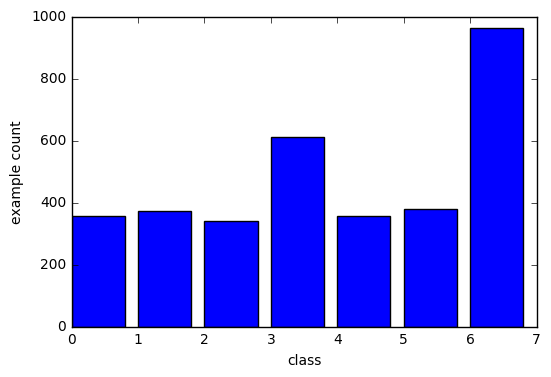

In [3]:
# exploreing the data:
npzfile = np.load('toronto_face.npz')
target_train = npzfile['target_train'].tolist()
print 'num of trainign image: ',len(target_train)
print 'max target value: ',max(target_train)
print "min target value: ",min(target_train)
counter = []
for i in range(7):
    counter.append( target_train.count(i) )
print counter
classes = ['Anger','Disgust','Fear','Happy','Sad','Suprised','Neutral']
plt.bar(range(7),counter)
plt.xlabel('class')
plt.ylabel('example count')

In [4]:
inputs_train, inputs_valid, inputs_test, target_train, target_valid, \
    target_test = LoadData('toronto_face.npz')
print inputs_train.shape
print inputs_valid.shape
print inputs_test.shape
print target_train.shape
print target_valid.shape
print target_test.shape
    


(3374, 2304)
(419, 2304)
(385, 2304)
(3374, 7)
(419, 7)
(385, 7)


In [5]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 2304])
y_ = tf.placeholder(tf.float32, shape=[None, 7])

In [7]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [8]:
# archtecture of the CNN: 3 CONV layers, 2 FC layers
x_image = tf.reshape(x, [-1,48,48,1])

W_conv1 = weight_variable([8, 8, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 48])
b_conv2 = bias_variable([48])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_conv3 = weight_variable([5, 5, 48, 64])
b_conv3 = bias_variable([64])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

W_fc1 = weight_variable([6 * 6 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, 6*6*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 7])
b_fc2 = bias_variable([7])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [9]:

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())


num_of_epoch = 100
batch_size = 241
num_of_data = inputs_train.shape[0]
iterations = num_of_data/batch_size*num_of_epoch

# list of number of epoch, accuracy and cross-entropy for training and validation
epoch_log = []
train_acc_log = []
val_acc_log = []
train_ce_log = []
val_ce_log = []

batch_num = 0

for iteration in range(iterations):
    # feeding images by batch    
    inputs_batch = inputs_train[batch_num*batch_size : (batch_num+1)*batch_size]
    target_batch = target_train[batch_num*batch_size : (batch_num+1)*batch_size]
    
    if batch_num >= num_of_data / batch_size - 1 :
        batch_num = 0
    else:
        batch_num = batch_num + 1
        
    # show the score after each epoch of the training
    if (iteration+1) % (num_of_data / batch_size ) == 0:     # when finish each epoch:     

        train_accuracy = accuracy.eval(feed_dict={
        x:inputs_batch, y_: target_batch, keep_prob: 1.0})
        print("epoch %d, training accuracy %g"%((iteration+1)/(num_of_data/batch_size), train_accuracy))
        epoch_log.append((iteration+1)/(num_of_data/batch_size))
        train_acc_log.append(train_accuracy)
        
        train_ce = cross_entropy.eval(feed_dict={
        x:inputs_batch, y_: target_batch, keep_prob: 1.0})
        train_ce_log.append(train_ce)
        
        val_accuracy = accuracy.eval(feed_dict={
        x:inputs_valid, y_: target_valid, keep_prob: 1.0})
        print("epoch %d, validation accuracy %g"%((iteration+1)/(num_of_data/batch_size), val_accuracy))
        val_acc_log.append(val_accuracy)
        
        val_ce = cross_entropy.eval(feed_dict={
        x:inputs_valid, y_: target_valid, keep_prob: 1.0})
        val_ce_log.append(val_ce)
        
    # training the neural network
    train_step.run(feed_dict={x: inputs_batch, y_: target_batch, keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: inputs_test, y_: target_test, keep_prob: 1.0}))

epoch 1, training accuracy 0.282158
epoch 1, validation accuracy 0.279236
epoch 2, training accuracy 0.294606
epoch 2, validation accuracy 0.288783
epoch 3, training accuracy 0.385892
epoch 3, validation accuracy 0.372315
epoch 4, training accuracy 0.493776
epoch 4, validation accuracy 0.465394
epoch 5, training accuracy 0.460581
epoch 5, validation accuracy 0.479714
epoch 6, training accuracy 0.543568
epoch 6, validation accuracy 0.544153
epoch 7, training accuracy 0.580913
epoch 7, validation accuracy 0.591885
epoch 8, training accuracy 0.580913
epoch 8, validation accuracy 0.610979
epoch 9, training accuracy 0.593361
epoch 9, validation accuracy 0.618138
epoch 10, training accuracy 0.60166
epoch 10, validation accuracy 0.618138
epoch 11, training accuracy 0.614108
epoch 11, validation accuracy 0.637232
epoch 12, training accuracy 0.630705
epoch 12, validation accuracy 0.642005
epoch 13, training accuracy 0.643154
epoch 13, validation accuracy 0.653938
epoch 14, training accuracy 0.6

In [10]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: inputs_test, y_: target_test, keep_prob: 1.0}))

test accuracy 0.794805


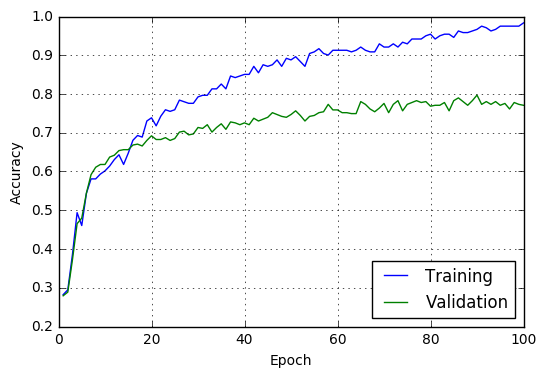

In [11]:
plt.plot(epoch_log, train_acc_log, label = 'Training')
plt.plot(epoch_log, val_acc_log, label = 'Validation')
legend = plt.legend(loc='lower right', fontsize='large')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

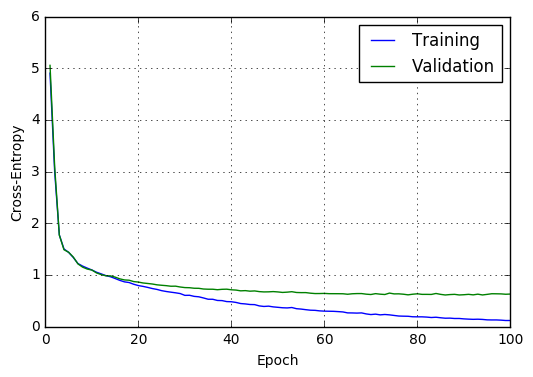

In [15]:
plt.plot(epoch_log, train_ce_log, label = 'Training')
plt.plot(epoch_log, val_ce_log, label = 'Validation')
legend = plt.legend(loc='upper right', fontsize='large')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.grid()

probability for each class:
[[ 0.          0.001       0.          0.99199998  0.          0.          0.006     ]]
correct label(one-hot):
[ 0.  0.  0.  1.  0.  0.  0.]


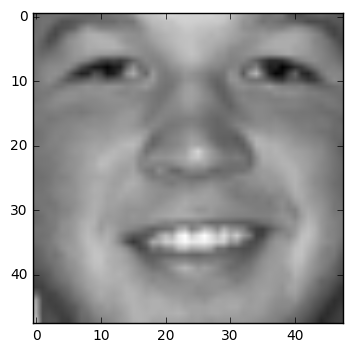

In [13]:
# show a sample prediction from test set
softmax = tf.nn.softmax(y_conv, dim=-1, name=None)
image = inputs_test[0].reshape(-1,2304)

print "probability for each class:" 
probability = softmax.eval(feed_dict={x: image, keep_prob: 1.0},session=sess)
probability = probability.round(3)
print probability
print "correct label(one-hot):"
print target_test[0]
image = image.reshape(48,48)
plt.figure()
plt.imshow(image,cmap='gray')



probability for each class:
[[ 0.001       0.          0.69800001  0.          0.002       0.27500001
   0.024     ]]
correct label(one-hot):
[ 0.  0.  1.  0.  0.  0.  0.]


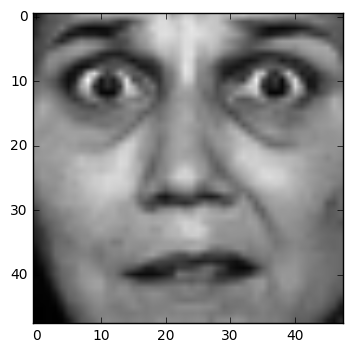

In [14]:
# another sample prediction: 
image = inputs_test[200].reshape(-1,2304)
print "probability for each class:" 
probability = softmax.eval(feed_dict={x: image, keep_prob: 1.0},session=sess)
probability = probability.round(3)
print probability
print "correct label(one-hot):"
print target_test[200]
image = image.reshape(48,48)
plt.figure()
plt.imshow(image,cmap='gray')